***
## DA 320 

#### Assignment: Final Class Project
#### Student: Natalia Sadkov 
#### Teacher: Professor T.Spence

***

In [41]:
# import libraries
import re
import urllib3
import certifi

***
#### Setup regular expressions for tilte, release date, description, metascore, image url
***

In [2]:
# constract all regular expressions
title_regex=re.compile(r"class=\"title\"><h3>(.+)</h3>")
date_regex=re.compile(r"class=\"clamp-details\">\s+<span>(.+)</span>")
description_regex=re.compile(r"<div class=\"summary\">\s*([\S\s]+?)\s*</div>")
score_regex = re.compile(r"<span class=\"title\">Metascore:</span>\s+<a class=\"metascore_anchor\" href=\"/movie/.*?/critic-reviews\">\s+<div class=\"metascore_w large movie .+\">(.*?)</div>")
image_regex = re.compile(r"<a href=\"/movie/.*\"><img src=\"(.*)\" alt=\"")

# Construct an HTTP pool for connection
http=urllib3.PoolManager(ca_certs=certifi.where())


***
#### Connect to mongoDB
***

In [3]:
import json
import pymongo
import certifi
# retrieve creditials to connect MongoDB
with open('/Users/natasha/Desktop/Fall 2022/DA320/Password MongoDB/credentials.json') as f:
    data = json.load(f)
    secret_key = data['mongodb']

# Connect to the database using known good certificates
client = pymongo.MongoClient(secret_key, tlsCAFile=certifi.where())
# Fetch the database named "DA-320"
da320_database = client['DA-320']

# Within the database we have "collections". Think of them as tables in SQL.
metacritic_data = da320_database['metacritic']

***
#### Web scraping function
***

In [4]:
import pandas as pd
#retrive a list of movies from a particular year and page of Metacritic
def metacritic_scraper (year:int,page:int) -> pd.DataFrame:
    #fetch the webpage
   url = f"https://www.metacritic.com/browse/movies/score/metascore/year/filtered?={year}&sort=desc&view=detailed&page={page}"
   # Construct python request pool
   response = http.request('GET',url,headers={'User-Agent':'Mozilla/5.0'})
   datastring = str(response.data, "utf-8")

   #execute all regular expression
   titles = title_regex.findall(datastring)
   dates = date_regex.findall(datastring)
   descriptions = description_regex.findall(datastring)
   scores = score_regex.findall(datastring)
   images = image_regex.findall(datastring)
   #return unified collection  
   print("title: " , len(titles), "date: " , len(dates), "description: " , len(descriptions), "score: " , len(scores), "image: " , len(images))
   dataset = {"title": titles, "date": dates, "description": descriptions, "score": scores, "image":images}
   return pd.DataFrame(dataset) 

***
#### Loop through years and pages
***

In [5]:
import re
import time

#Write a CVS file with this data
for year in range(2000,2023):
   page=0
   print(f"Collection date for {year} page {page}.....")

   #retry a page multiple times
   while True:
      data = metacritic_scraper(year,page)

      #stop when we reach a page with zero rows
      if len(data) == 0:
         break

      #conver the dataframe into a list of movies to insert into Mongo DB
      movies_to_insert =[]
      for row in data.itertuples():
         movie = {
            "title": row.title,
            "release_date": row.date,
            "description": row.description,
            "metascore": row.score,
            "image_url": row.image,
         }
         movies_to_insert.append(movie)
         
      #insert resords into MongoDB
      print(f"Inserting{len(movies_to_insert)} moview for year {year} page {page}")
      metacritic_data.insert_many(movies_to_insert)
      page = page+1

Collection date for 2000 page 0.....
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2000 page 0
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2000 page 1
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2000 page 2
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2000 page 3
title:  78 date:  78 description:  78 score:  78 image:  78
Inserting78 moview for year 2000 page 4
title:  0 date:  0 description:  0 score:  0 image:  0
Collection date for 2001 page 0.....
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2001 page 0
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2001 page 1
title:  100 date:  100 description:  100 score:  100 image:  100
Inserting100 moview for year 2001 page 2
title:  100 date:  100 descri

***
#### Retrieving a collection from MongoDB
***

In [6]:
import json
import pymongo
import certifi
import pandas

# Retrieve credentials for SQL Server from our credentials file
with open('/Users/natasha/Desktop/Fall 2022/DA320/Password MongoDB/credentials.json') as f:
   data = json.load(f)
   secret_key = data['mongodb']

# Fetch the database named "DA-320"

client = pymongo.MongoClient (secret_key, tlsCAFile=certifi.where())
da320_database = client['DA-320']
metactritic_data = da320_database['metacritic_new_2']
metacritic = pandas.DataFrame(metacritic_data.find())

***
#### Transforming data in Pandas
***

In [7]:
# Convert release dates into actual dates and gather year/month
metacritic.release_date = pandas.to_datetime (metacritic.release_date)
metacritic['year'] = metacritic.release_date.dt.year
metacritic['month'] = metacritic.release_date.dt.month
metacritic.metascore = pandas.to_numeric(metacritic.metascore)
metacritic.head()

,_id,title,release_date,description,metascore,image_url,year,month
0,636c60d50b81c439d9299136,Aftersun,2022-10-21,Sophie reflects on the shared joy and private ...,95,https://static.metacritic.com/images/products/...,2022,10
1,636c60d50b81c439d9299137,Mr. Bachmann and His Class,2022-02-20,In a German city with a complex history of bot...,92,https://static.metacritic.com/images/products/...,2022,2
2,636c60d50b81c439d9299138,TÁR,2022-10-07,Set in the international world of classical mu...,91,https://static.metacritic.com/images/products/...,2022,10
3,636c60d50b81c439d9299139,The Worst Person in the World,2022-02-04,Director Joachim Trier returns with another mo...,90,https://static.metacritic.com/images/products/...,2022,2
4,636c60d50b81c439d929913a,Hit the Road,2022-04-22,A family of four – two middle-aged parents and...,90,https://static.metacritic.com/images/products/...,2022,4


Creating an XY (scatter) plot

***
### Comparing histograms by keywords Sad and Happy
***

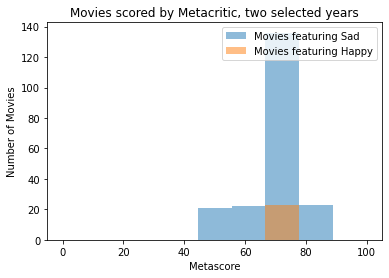

In [38]:
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
import numpy

# Retrieve metascore for happy and sad in description
scores_happy = metacritic[metacritic['description'].str.contains("happy")].metascore
scores_sad = metacritic[metacritic['description'].str.contains("sad")].metascore


# Plot into buckets
bins = numpy.linspace(0, 100, 10)
pyplot.title("Movies scored by Metacritic, two selected years")
pyplot.xlabel('Metascore')
pyplot.ylabel('Number of Movies')
pyplot.hist (scores_sad, bins, alpha=0.5, label='Movies featuring Sad')
pyplot.hist (scores_happy, bins, alpha=0.5, label='Movies featuring Happy')
pyplot.legend (loc='upper right')

pyplot.show()

#### Findings: It is interesting that "sad" is spreading of Metascore range very wide in comprare with "happy" and amount of movies that have word "sad" in discription are noticable
